# Projeto Visão computacional - Reconhecimento da íris 

### objetivo:

- 1. Criar um modelo de treinamento usando a base de dados fornecida - melhorar a qualidade das imagens
- 2. obter a matriz de confusão do modelo 
- 3. analisar os resultados

***Nomes:*** Samuel Porto & Thalia Loiola

In [1]:
import os
import cv2
import pywt
import cv2 as cv
import numpy as np
from os import walk
import pandas as pd
import G6_iris_recognition
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

In [2]:
# função de sharpen para imagens
# fonte: https://en.wikipedia.org/wiki/Unsharp_masking#Digital_unsharp_masking
def sharpen_image(img, kernel_size=(5, 5), sigma=1.5, amount=2.0, threshold=0):
    blurred = cv2.GaussianBlur(img, kernel_size, sigma)

    # formula para melhorar a nitidez da imagem 
    sharpened = float(amount + 1) * img - float(amount) * blurred

    sharpened = np.maximum(sharpened, np.zeros(sharpened.shape))
    sharpened = np.minimum(sharpened, 255 * np.ones(sharpened.shape))
    sharpened = sharpened.round().astype(np.uint8)

    if threshold > 0:
        low_contrast_mask = np.absolute(img - blurred) < threshold
        np.copyto(sharpened, img, where=low_contrast_mask)

    return sharpened

In [3]:
# função de melhora de brilho e contraste nas imagens
def apply_brightness_contrast(input_img, brightness = 0, contrast = 0):
    if brightness != 0:
        if brightness > 0:
            shadow = brightness
            highlight = 255
        else:
            shadow = 0
            highlight = 255 + brightness
        alpha_b = (highlight - shadow)/255
        gamma_b = shadow
        
        buf = cv2.addWeighted(input_img, alpha_b, input_img, 0, gamma_b)
    else:
        buf = input_img.copy()
    
    if contrast != 0:
        f = 131*(contrast + 127)/(127*(131-contrast))
        alpha_c = f
        gamma_c = 127*(1-f)
        
        buf = cv2.addWeighted(buf, alpha_c, buf, 0, gamma_c)

    return buf

## Análise das características de uma imagem

Antes de tratar todas as imagens para o modelo de treinamento, fez-se uma análise individual de uma amostra afim de observar comportamentos específicos e possíveis melhoras na qualidade da imagem que poderiam ser aplicada as demais.

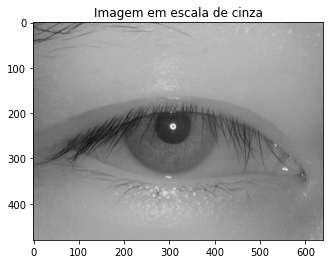

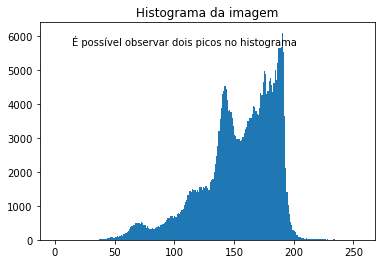

In [4]:
#Análise do histograma de uma imagem
image = cv2.imread('images/0000/0000_008.bmp')
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

plt.imshow(img, 'gray')
plt.title('Imagem em escala de cinza')
plt.show()

plt.hist(img.ravel(),bins=255,range=[0,255]) # da pra ver melhor os dois picos no range=[100,225]
plt.title('Histograma da imagem')
plt.figtext(.2, .8, 'É possível observar dois picos no histograma')
plt.show()

É possível observar que a imagem possui dois picos de contraste, caso simplesmente equalizássemos a imagem esses dois picos ainda provocariam uma concentração de intensidades entre eles. Tendo isto em vista, foi utilizada a função CLAHE da biblioteca cv2 que remove picos de contraste para uma melhor equalização da imagem posteriormente, com o objetivo de evidenciar as características das imagens melhor, como mostrado abaixo:

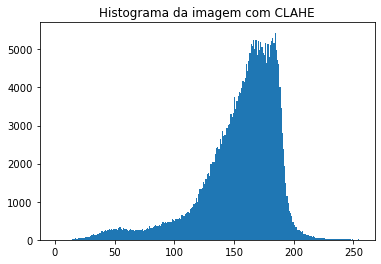

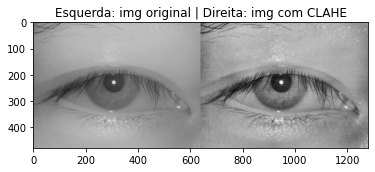

In [100]:
#Aplicação da função CLAHE na imagem desejada
clahe = cv2.createCLAHE(clipLimit =2.0, tileGridSize=(8,8))
cl_img = clahe.apply(img)

# TRANSFORMAÇAO DO HISTOGRAMA PARA UM DE APENAS UM PICO
plt.hist(cl_img.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com CLAHE')
plt.show()

# imagem tradata
plt.imshow(np.hstack((img, cl_img)), 'gray')
plt.title('Esquerda: img original | Direita: img com CLAHE')
plt.show()

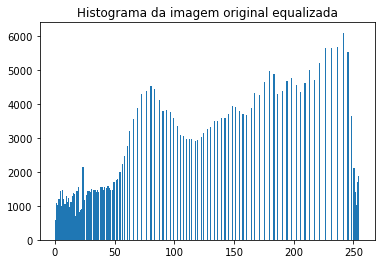

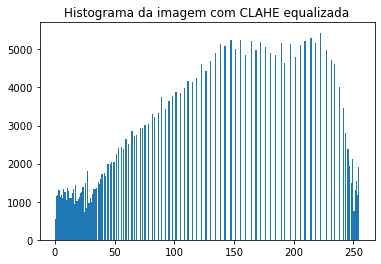

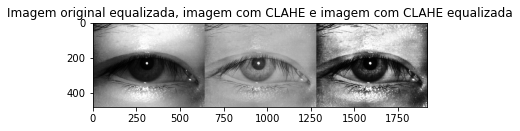

In [113]:
# equalizacao as imagens
img_equ = cv2.equalizeHist(img)

cl_img_equ = cv2.equalizeHist(cl_img)

plt.hist(img_equ.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem original equalizada')
plt.show()

plt.hist(cl_img_equ.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com CLAHE equalizada')
plt.show()

plt.imshow(np.hstack((img_equ , cl_img, cl_img_equ)), 'gray')
plt.title('Imagem original equalizada, imagem com CLAHE e imagem com CLAHE equalizada')
plt.show()

É possível observar que a imagem que possui um contraste melhor e consegue evidenciar de maneira mais significativas os detalhes da íris, é a imagem do meio. A imagem do meio é a imagem original somente com o CLAHE, abaixo segue outras etapas de pré-processamento adotadas, com o intuito de deixar a imagem mais preparada, buscando um desempenho melhor no treinamento.

## Procedimentos de tratamento da imagem com CLAHE

Uma passo interessante é aplicar sharppening na imagem, pois, assim detalhes da íris podem ser evidenciados. Duas funções de sharpen foram testadas, a primeira é aplicação do produto de convulução como vimos em aula do `filter2D` e a segunda foi a função `sharpen_image()`, que foi buscada na literatura e possui sua referência citada no começo desse arquivo.

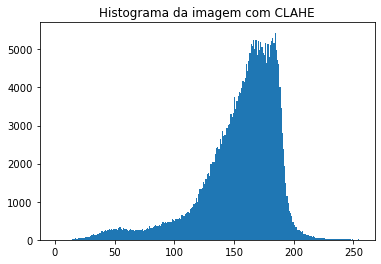

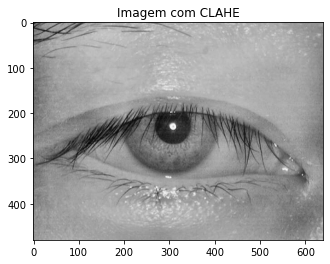

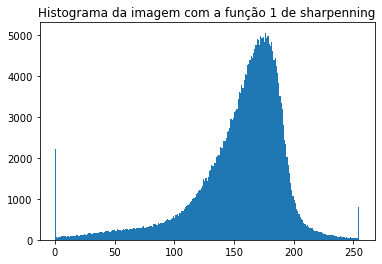

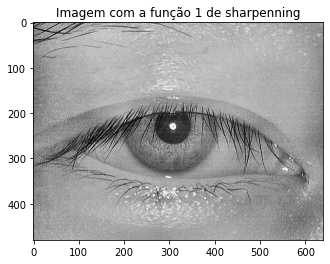

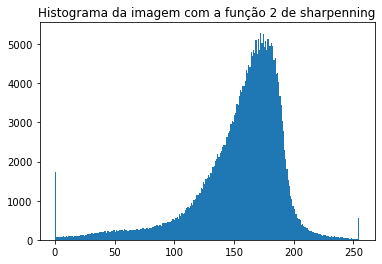

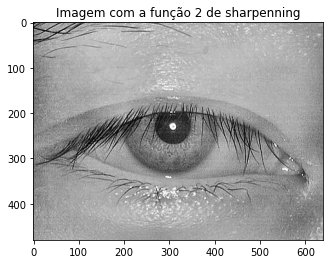

In [129]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])

imgs_1 = cv2.filter2D(cl_img, -1, kernel)

imgs_2 = sharpen_image(cl_img)

plt.hist(cl_img.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com CLAHE')
plt.show()
plt.imshow(cl_img, 'gray')
plt.title('Imagem com CLAHE')
plt.show()

plt.hist(imgs_1.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com a função 1 de sharpenning')
plt.show()
plt.imshow(imgs_1, 'gray')
plt.title('Imagem com a função 1 de sharpenning')
plt.show()

plt.hist(imgs_2.ravel(),bins=255,range=[0,255])
plt.title('Histograma da imagem com a função 2 de sharpenning')
plt.show()
plt.imshow(imgs_2, 'gray')
plt.title('Imagem com a função 2 de sharpenning')
plt.show()

Após observar os resultados, concluiu-se que a imagem com CLAHE depois de aplicar o filtro de shapen com o produto de convolução como vimos em aula `imgs_1`, possui uma distribuição em seu histograma mais uniforme. Dessa maneira, decidimos seguir com ela para as próximas etapas de pré-processamento.

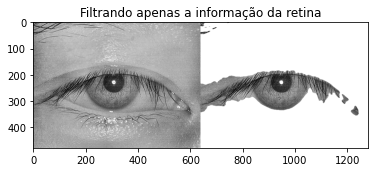

In [147]:
#Binarizamos a imagem e depois borramos para obter uma mascára em que somente os detalhes da retina estejam presentes
T, img_bin = cv.threshold(img,127,255,cv.THRESH_BINARY)

img_bin = cv.GaussianBlur(img_bin,(11,11),50)

new_img = imgs_1.copy()

rows, cols = new_img.shape

#Aplicamos a máscara preto e branca para excluir as informações que não sejam da íris
for l in range(rows):
    for c in range(cols):
        if img_bin[l][c] > T:
            new_img[l][c] = 255

plt.imshow(np.hstack((imgs_1,new_img)), 'gray')
plt.title('Filtrando apenas a informação da retina')
plt.show()

## Aplicando as etapas selecionadas de pré-processamento para todas as imagens

In [154]:
#Essa função percorre as pastas das imagens, trata elas com as etapas de preprocessamento anteriores
#e salva elas em respectivas pastas pra cada pessoa que serão usadas no treinamento
def percorre_pastas(num_pasta):
    for (dirpath, dirnames, filenames) in walk("images/00{}".format(num_pasta)):
        for e in filenames:
            image = cv.imread("images/00{0}/{1}".format(num_pasta, e))
            img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            
            #Aplicando o CLAHE, sharpening e as outras etapas de preprocessamento na imagem
            clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
            
            cl_img = clahe.apply(img)
            
#             imgs_1 = cv2.filter2D(cl_img, -1, kernel)

            directory ="images_processadas/images_processadas_{0}/00{0}/".format(num_pasta)
            
            #Cria o diretório de cada pessoa com as imagens novas já tratadas
            if not os.path.exists(directory):
                os.makedirs(directory)

            filename = "images_processadas/images_processadas_{0}/00{0}/{1}".format(num_pasta, e)
            
            cv.imwrite(filename, imgs_1)

In [156]:
# processamento para varias imagens
n_pastas = 60

for i in range(0, n_pastas):
    if i < 10:
        n ="0{}".format(i)
    else :
        n = i   
    percorre_pastas(n)

## Treinar o modelo para as imagens válidas

In [157]:
#Para cada pessoa com a imagem ja processada, treinamos o modelo para conseguir classificar a pessoa        
for i in range(0, n_pastas):
    if i < 10:
        n ="0{}".format(i)
    else :
        if i == 12: 
            i = 13
        n = i
    
    #Selecionamos as apenas as imagens que são válidas e conseguem ser treinadas, as demais são usadas na prdição
    valid_images = G6_iris_recognition.iris_model_train("./images_processadas/images_processadas_{0}".format(n),"model.pickle")
    
    directory ="valid_images/00{0}/".format(n)
    
    #Criamos a pasta com apenas as imagens válidas para o treino
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    for image in valid_images[1]:
        name = image.split('\\')[2]
                
        filename = "valid_images/00{0}/{1}".format(n, name)
        image = cv.imread("images_processadas/images_processadas_{0}/00{0}/{1}".format(n, name))
        
        cv.imwrite(filename, image)

directory_list ['./images_processadas/images_processadas_00\\0000']
name 0000
path_to_image ./images_processadas/images_processadas_00\0000\0000_000.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_001.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_002.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_00\0000\0000_003.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_004.bmp
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
path_to_image ./images_processadas/images_processadas_00\0000\0000_005.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_006.bmp
path_to_image ./images_processadas/images_processadas_00\0000\0000_007.bmp
locate expression 1 local vari

In [5]:
#Apos selecionadas as imagens que funcionam para o nosso modelo vamos treinar apenas elas
valid_images = G6_iris_recognition.iris_model_train("./valid_images","model.pickle")

directory_list ['./valid_images\\0000', './valid_images\\0001', './valid_images\\0002', './valid_images\\0003', './valid_images\\0004', './valid_images\\0005', './valid_images\\0006', './valid_images\\0007', './valid_images\\0008', './valid_images\\0009', './valid_images\\0010', './valid_images\\0011', './valid_images\\0013', './valid_images\\0014', './valid_images\\0015', './valid_images\\0016', './valid_images\\0017', './valid_images\\0018', './valid_images\\0019', './valid_images\\0020', './valid_images\\0021', './valid_images\\0022', './valid_images\\0023', './valid_images\\0024', './valid_images\\0025', './valid_images\\0026', './valid_images\\0027', './valid_images\\0028', './valid_images\\0029', './valid_images\\0030', './valid_images\\0031', './valid_images\\0032', './valid_images\\0033', './valid_images\\0034', './valid_images\\0035', './valid_images\\0036', './valid_images\\0037', './valid_images\\0038', './valid_images\\0039', './valid_images\\0040', './valid_images\\0041', 

path_to_image ./valid_images\0011\0011_002.bmp
path_to_image ./valid_images\0011\0011_003.bmp
path_to_image ./valid_images\0011\0011_004.bmp
path_to_image ./valid_images\0011\0011_005.bmp
path_to_image ./valid_images\0011\0011_006.bmp
path_to_image ./valid_images\0011\0011_007.bmp
path_to_image ./valid_images\0011\0011_008.bmp
path_to_image ./valid_images\0011\0011_010.bmp
path_to_image ./valid_images\0011\0011_011.bmp
path_to_image ./valid_images\0011\0011_012.bmp
path_to_image ./valid_images\0011\0011_014.bmp
name 0013
path_to_image ./valid_images\0013\0013_005.bmp
path_to_image ./valid_images\0013\0013_010.bmp
path_to_image ./valid_images\0013\0013_014.bmp
name 0014
path_to_image ./valid_images\0014\0014_000.bmp
path_to_image ./valid_images\0014\0014_001.bmp
path_to_image ./valid_images\0014\0014_002.bmp
path_to_image ./valid_images\0014\0014_003.bmp
path_to_image ./valid_images\0014\0014_005.bmp
path_to_image ./valid_images\0014\0014_006.bmp
path_to_image ./valid_images\0014\0014_0

path_to_image ./valid_images\0024\0024_003.bmp
path_to_image ./valid_images\0024\0024_004.bmp
path_to_image ./valid_images\0024\0024_005.bmp
path_to_image ./valid_images\0024\0024_006.bmp
path_to_image ./valid_images\0024\0024_008.bmp
path_to_image ./valid_images\0024\0024_009.bmp
path_to_image ./valid_images\0024\0024_010.bmp
path_to_image ./valid_images\0024\0024_011.bmp
path_to_image ./valid_images\0024\0024_012.bmp
path_to_image ./valid_images\0024\0024_015.bmp
path_to_image ./valid_images\0024\0024_018.bmp
name 0025
path_to_image ./valid_images\0025\0025_014.bmp
name 0026
path_to_image ./valid_images\0026\0026_000.bmp
path_to_image ./valid_images\0026\0026_001.bmp
path_to_image ./valid_images\0026\0026_002.bmp
path_to_image ./valid_images\0026\0026_003.bmp
path_to_image ./valid_images\0026\0026_004.bmp
path_to_image ./valid_images\0026\0026_005.bmp
path_to_image ./valid_images\0026\0026_006.bmp
path_to_image ./valid_images\0026\0026_007.bmp
path_to_image ./valid_images\0026\0026_0

path_to_image ./valid_images\0036\0036_015.bmp
path_to_image ./valid_images\0036\0036_016.bmp
path_to_image ./valid_images\0036\0036_017.bmp
path_to_image ./valid_images\0036\0036_018.bmp
path_to_image ./valid_images\0036\0036_019.bmp
name 0037
path_to_image ./valid_images\0037\0037_001.bmp
path_to_image ./valid_images\0037\0037_002.bmp
path_to_image ./valid_images\0037\0037_003.bmp
path_to_image ./valid_images\0037\0037_004.bmp
path_to_image ./valid_images\0037\0037_005.bmp
path_to_image ./valid_images\0037\0037_006.bmp
path_to_image ./valid_images\0037\0037_007.bmp
path_to_image ./valid_images\0037\0037_008.bmp
path_to_image ./valid_images\0037\0037_009.bmp
path_to_image ./valid_images\0037\0037_010.bmp
path_to_image ./valid_images\0037\0037_011.bmp
path_to_image ./valid_images\0037\0037_012.bmp
path_to_image ./valid_images\0037\0037_013.bmp
path_to_image ./valid_images\0037\0037_014.bmp
path_to_image ./valid_images\0037\0037_015.bmp
path_to_image ./valid_images\0037\0037_016.bmp
pat

path_to_image ./valid_images\0050\0050_015.bmp
path_to_image ./valid_images\0050\0050_016.bmp
path_to_image ./valid_images\0050\0050_017.bmp
path_to_image ./valid_images\0050\0050_018.bmp
path_to_image ./valid_images\0050\0050_019.bmp
name 0051
path_to_image ./valid_images\0051\0051_000.bmp
path_to_image ./valid_images\0051\0051_001.bmp
path_to_image ./valid_images\0051\0051_004.bmp
path_to_image ./valid_images\0051\0051_005.bmp
path_to_image ./valid_images\0051\0051_006.bmp
path_to_image ./valid_images\0051\0051_009.bmp
path_to_image ./valid_images\0051\0051_015.bmp
name 0052
path_to_image ./valid_images\0052\0052_000.bmp
path_to_image ./valid_images\0052\0052_001.bmp
path_to_image ./valid_images\0052\0052_002.bmp
path_to_image ./valid_images\0052\0052_003.bmp
path_to_image ./valid_images\0052\0052_004.bmp
path_to_image ./valid_images\0052\0052_005.bmp
path_to_image ./valid_images\0052\0052_006.bmp
path_to_image ./valid_images\0052\0052_007.bmp
path_to_image ./valid_images\0052\0052_0

## Testar o modelo para prever as categorias das pessoas

In [6]:
#Durante o teste das predições, contabilizamos o número de estimativas certas e erradas
n_pastas = 60

classificacao_certa = 0
classificacao_errada = 0
unmatch = 0

#Criamos um DataFrame com as informações dos valores reais e predito para usarmos na matriz de confusão e qualificar o modelo
data = {'atual': [],
        'predito': []
        }

info = pd.DataFrame(data)

for i in range(0, n_pastas):
    if i < 10:
        n ="0{}".format(i)
    else :
        if i == 12: 
            i = 13
        n = i   
    
    #Testando para cada imagem de cada pessoa
    for (dirpath, dirnames, filenames) in walk("./images_processadas/images_processadas_{0}/00{0}".format(n)):
        for e in filenames:
            classificado = G6_iris_recognition.iris_model_test("model.pickle","./images_processadas/images_processadas_{0}/00{0}/{1}".format(n,e))
            
            #Atualizando os variaveis de classificacao
            if classificado == "00{}".format(n):
                classificacao_certa += 1
            elif classificado == "unmatch":
                unmatch += 1
            else:
                classificacao_errada += 1
            
            #Atualizando o DataFrame
            info = info.append({'atual': "00{}".format(n), "predito": classificado}, ignore_index=True)

print(" certa:{0}\n errada:{1}\n unmatch:{2}".format(classificacao_certa, classificacao_errada, unmatch))

rectangle expression1
rectangle expression1
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 local variable 'east_mark' referenced before assignment
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectan

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle 

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
rectangle expression1
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 wi

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (exp

locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
locate expression 1 index 640 is out of bounds for axis 1 with size 640
rectangle expression2 not enough values to unpack (expected 2, got 1)
rectangle expression1
rectangle expression1
 certa:2
 errada:791
 unmatch:390


In [10]:
info

,atual,predito
0,0000,0045
1,0000,0045
2,0000,0045
3,0000,0025
4,0000,unmatch
...,...,...
1178,0059,0045
1179,0059,unmatch
1180,0059,unmatch
1181,0059,unmatch


## Análise de resultado através da matriz de correlação

<ipython-input-8-267eb81322fd>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['pred'] = pessoa == df['predito']
<ipython-input-8-267eb81322fd>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['atual'] = pessoa == df['atual']


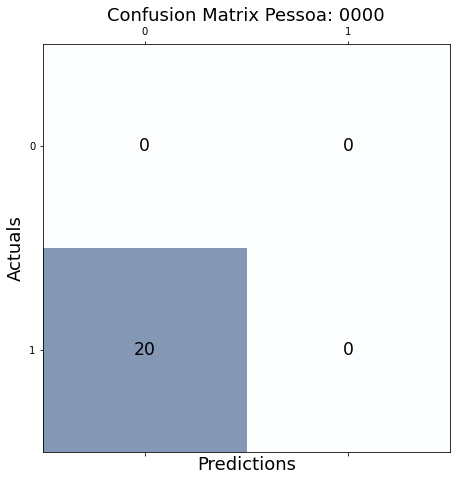

In [8]:
#Vamos tratar o DataFrame resultante para conseguir gerar as matrizes de confusão
dataframe = info.copy()

pessoas = list(dataframe.atual.unique())

pessoa_data = []

for pessoa in pessoas:
    #Criando um novo dataframe por pessoa
    df = dataframe[dataframe['atual'] == pessoa]
    
    #Criando uma nova coluna para verificar se o valor predito foi certo
    df['pred'] = pessoa == df['predito']

    df['atual'] = pessoa == df['atual']
    
    conf_matrix = confusion_matrix(y_true=df.atual, y_pred=df.pred)

    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')

    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix Pessoa: {}'.format(pessoa), fontsize=18)
    plt.show()
    
    #Para visualizar as matrizes de correlação de cada pessoa basta remover o break
    #A interpretação da matriz é semelhante para todas as pessoas
    break

O resultado da matriz de confusão acima mostra que existem 20 imagens em que a pessoa zero é ela mesmo (linha 1, coluna 0), contudo, nosso modelo previu nessas 20 vezes que a pessoa 1 não era ela, se mostrando não muito eficaz para a classificação mesmo depois do pré-processamento.

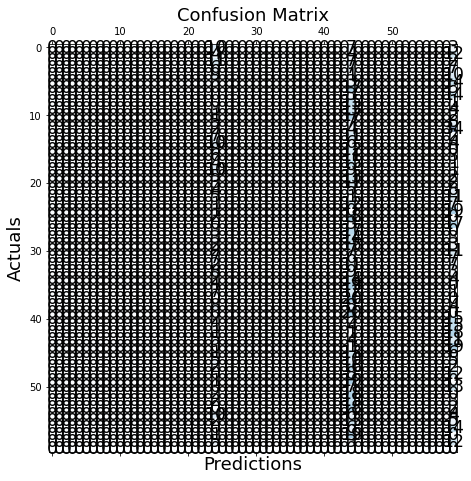

In [9]:
#Montando a matriz de confusão para todas as pessoas ao mesmo tempo
conf_matrix = confusion_matrix(y_true=dataframe.atual, y_pred=dataframe.predito)

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.5)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')


plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

A última linha e última coluna da matriz de consfusão acima representa a categoria "unmatch", ou seja, a a soma dos elementos da ultima linha mostram quantos pessoas com o nome "unmatch" inicialmente existiam e a soma dos elementos da última coluna são a soma de quantas pessoas são classificadas como "unmatch" pelo modelo.
Nosso modelo previu poucas vezes corretamente, esses valores estão representados na diagonal principal da matriz. Contudo, ele previu muitas vezes "unmatch" e também associou as pessoas as classificações erradas.

## Considerações

Tivemos uma curva de aprendizado alto para entender o funcionamento da biblioteca `G6_iris_recognition`, contudo, outras etapas de pré-processamento podem ser adicionadas para aumentar a qualidade do conjunto de treinamento, como alterar os canais de uma transformada de wavelet aplicando sharpenning, blur, entre outros procedimentos estudados e verificar se essas medidas são eficazes para a melhora da imagem.

Outro ponto importante de ressaltar é que alteramos a biblioteca `G6_iris_recognition` para retornar os nomes dos arquivos que são válidos para o treinamento depois da etapa de processamento, dessa forma, foi possível automatizar os treinamenos e testes.